In [1]:
import torch
from torch_geometric.utils import to_networkx, from_networkx
from sklearn import metrics
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/users/Min/miniconda/envs/hy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
edge = torch.load('/dev/shm/twi22/processed_data/edge_index.pt')
edge.shape

torch.Size([2, 3743634])

In [1]:
label = torch.load('/dev/shm/twi20/processed_data/label.pt')
label.shape

NameError: name 'torch' is not defined

In [ ]:
train_idx = torch.load('twi20/train_idx.pt')
val_idx = torch.load('twi20/val_idx.pt')
test_idx = torch.load('twi20/test_idx.pt')
train_idx.shape,val_idx.shape,test_idx.shape


In [ ]:
path = 'twi20/'
num,cat =  torch.load(path+'num_properties_tensor.pt'), torch.load(path+'cat_properties_tensor.pt')
num.shape,cat.shape

In [ ]:
label[train_idx],label[train_idx].shape

In [ ]:
torch.sum(label[train_idx]).item()/label[train_idx].shape[0],torch.sum(label[val_idx]).item()/label[val_idx].shape[0],torch.sum(label[test_idx]).item()/label[test_idx].shape[0]

In [ ]:
train_idx

In [ ]:
node_idx = torch.cat([train_idx,val_idx,test_idx],dim=0)
node_idx.shape

In [ ]:
x = torch.cat([num,cat],dim=1)
x.shape

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_neighbor_similarity(edge, x, node_idx, label):
    # 构建一个邻接表
    num_nodes = x.size(0)
    edge_index = edge  # shape [2, num_edges]

    # 创建邻接表（有标签节点之间的连接）
    adj_dict = defaultdict(list)
    labeled_set = set(node_idx.tolist())

    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    for src, dst in zip(src_nodes.tolist(), dst_nodes.tolist()):
        if src in labeled_set and dst in labeled_set:
            adj_dict[src].append(dst)

    # 准备相似度列表
    human_human_sim = []
    human_bot_sim = []
    bot_bot_sim = []
    bot_human_sim = []

    for node in node_idx.tolist():
        node_label = label[node].item()
        node_feat = x[node]

        neighbors = adj_dict[node]
        for nei in neighbors:
            nei_label = label[nei].item()
            nei_feat = x[nei]

            sim = F.cosine_similarity(node_feat.unsqueeze(0), nei_feat.unsqueeze(0)).item()

            if node_label == 0:  # human node
                if nei_label == 0:
                    human_human_sim.append(sim)
                else:
                    human_bot_sim.append(sim)
            else:  # bot node
                if nei_label == 1:
                    bot_bot_sim.append(sim)
                else:
                    bot_human_sim.append(sim)

    return human_human_sim, human_bot_sim, bot_bot_sim, bot_human_sim


# 绘图
def plot_bar_chart(hh, hb, bb, bh):
    categories = ['Human-Human', 'Human-Bot', 'Bot-Bot', 'Bot-Human']
    means = [
        sum(hh) / len(hh) if hh else 0,
        sum(hb) / len(hb) if hb else 0,
        sum(bb) / len(bb) if bb else 0,
        sum(bh) / len(bh) if bh else 0,
    ]

    plt.figure(figsize=(8, 5))
    plt.bar(categories, means, color=['blue', 'orange', 'green', 'red'])
    plt.ylabel('Average Cosine Similarity')
    plt.title('Cosine Similarity between Node and Its Labeled Neighbors')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [ ]:

# 调用函数
hh_sim, hb_sim, bb_sim, bh_sim = compute_neighbor_similarity(edge, x, node_idx, label)
hh_sim, hb_sim, bb_sim, bh_sim

In [ ]:

# 画图
plot_bar_chart(hh_sim, hb_sim, bb_sim, bh_sim)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_distribution(hh, hb, bb, bh):
    # 计算均值
    mean_hh = np.mean(hh) if hh else 0
    mean_hb = np.mean(hb) if hb else 0
    mean_bb = np.mean(bb) if bb else 0
    mean_bh = np.mean(bh) if bh else 0

    print(f"Mean Similarity:")
    print(f"Human-Human: {mean_hh:.4f}")
    print(f"Human-Bot  : {mean_hb:.4f}")
    print(f"Bot-Bot    : {mean_bb:.4f}")
    print(f"Bot-Human  : {mean_bh:.4f}")

    # 设置 seaborn 样式
    sns.set(style="whitegrid")

    # 创建一个图
    plt.figure(figsize=(10, 6))

    # 画分布图
    sns.kdeplot(hh, label=f'Human-Human (mean={mean_hh:.3f})', linewidth=2, color='blue')
    sns.kdeplot(hb, label=f'Human-Bot (mean={mean_hb:.3f})', linewidth=2, color='orange')
    sns.kdeplot(bb, label=f'Bot-Bot (mean={mean_bb:.3f})', linewidth=2, color='green')
    sns.kdeplot(bh, label=f'Bot-Human (mean={mean_bh:.3f})', linewidth=2, color='red')

    plt.title('Distribution of Cosine Similarity with Labeled Neighbors')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(-1, 1)  # Cosine similarity is in [-1, 1]
    plt.tight_layout()
    plt.show()

# 调用
plot_distribution(hh_sim, hb_sim, bb_sim, bh_sim)


In [ ]:
def plot_cdf(hh, hb, bb, bh):
    plt.figure(figsize=(10, 6))

    def cdf(data):
        data = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return data, y

    x_hh, y_hh = cdf(hh)
    x_hb, y_hb = cdf(hb)
    x_bb, y_bb = cdf(bb)
    x_bh, y_bh = cdf(bh)

    plt.plot(x_hh, y_hh, label=f'Human-Human', color='blue')
    plt.plot(x_hb, y_hb, label=f'Human-Bot', color='orange')
    plt.plot(x_bb, y_bb, label=f'Bot-Bot', color='green')
    plt.plot(x_bh, y_bh, label=f'Bot-Human', color='red')

    plt.title("CDF of Cosine Similarity")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_cdf(hh_sim, hb_sim, bb_sim, bh_sim)

In [ ]:
def compute_neighbor_similarity(edge, x, node_idx, label):
    # 构建一个邻接表
    num_nodes = x.size(0)
    edge_index = edge  # shape [2, num_edges]

    # 创建邻接表（有标签节点之间的连接）
    adj_dict = defaultdict(list)
    labeled_set = set(node_idx.tolist())

    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    for src, dst in zip(src_nodes.tolist(), dst_nodes.tolist()):
        if src in labeled_set and dst in labeled_set:
            adj_dict[src].append(dst)

    # 准备相似度列表
    human_nei_sim = []
    bot_nei_sim = []
    

    for node in node_idx.tolist():
        node_label = label[node].item()
        node_feat = x[node]

        neighbors = adj_dict[node]
        for nei in neighbors:
            # nei_label = label[nei].item()
            nei_feat = x[nei]

            sim = F.cosine_similarity(node_feat.unsqueeze(0), nei_feat.unsqueeze(0)).item()

            if node_label == 0:  # human node
                human_nei_sim.append(sim)
                
            else:  # bot node
                bot_nei_sim.append(sim)

    return human_nei_sim, bot_nei_sim

In [ ]:
human_nei_sim, bot_nei_sim = compute_neighbor_similarity(edge, x, node_idx, label)
np.mean(human_nei_sim), np.mean(bot_nei_sim)

In [ ]:
def plot_cdf(h_sim, b_sim):
    plt.figure(figsize=(10, 6))

    def cdf(data):
        data = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return data, y

    x_hh, y_hh = cdf(h_sim)
    x_bb, y_bb = cdf(b_sim)

    plt.plot(x_hh, y_hh, label=f'Human', color='blue')
    # plt.plot(x_hb, y_hb, label=f'Human-Bot', color='orange')
    plt.plot(x_bb, y_bb, label=f'Bot', color='green')
    # plt.plot(x_bh, y_bh, label=f'Bot-Human', color='red')

    plt.title("CDF of Cosine Similarity")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_cdf(human_nei_sim, bot_nei_sim)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
from tqdm import tqdm

def compute_bot_similarity_by_distance(edge, x, node_idx, label):
    num_nodes = x.size(0)
    edge_np = edge.cpu().numpy()
    
    # 构建邻接矩阵（无向图）
    A = coo_matrix((np.ones(edge_np.shape[1]), (edge_np[0], edge_np[1])), shape=(num_nodes, num_nodes))
    A = A + A.T  # 无向图
    A = A.tocsr()

    # 仅考虑 labeled 节点（更小规模）
    labeled_nodes = node_idx.cpu().numpy()
    label_np = label.cpu().numpy()

    # 子图：只考虑有标签节点
    node_map = {old: new for new, old in enumerate(labeled_nodes)}
    x_labeled = x[labeled_nodes]
    label_labeled = label_np[labeled_nodes]

    # 重新映射边
    mask_src = np.isin(edge_np[0], labeled_nodes)
    mask_dst = np.isin(edge_np[1], labeled_nodes)
    mask = mask_src & mask_dst
    edge_sub = edge_np[:, mask]
    edge_sub = np.vectorize(node_map.get)(edge_sub)

    # 构建子图邻接矩阵
    sub_A = coo_matrix((np.ones(edge_sub.shape[1]), (edge_sub[0], edge_sub[1])), shape=(len(labeled_nodes), len(labeled_nodes)))
    sub_A = sub_A + sub_A.T
    sub_A = sub_A.tocsr()

    # 最短路径距离矩阵
    dist_matrix = shortest_path(sub_A, directed=False, unweighted=True)

    # 相似度存储
    bb_short, bh_short, bb_long, bh_long = [], [], [], []

    for i in tqdm(range(len(labeled_nodes)), desc="Computing similarities"):
        if label_labeled[i] != 1:  # 只分析 bot 节点
            continue
        for j in range(len(labeled_nodes)):
            if i == j or np.isinf(dist_matrix[i, j]):
                continue
            sim = F.cosine_similarity(x_labeled[i].unsqueeze(0), x_labeled[j].unsqueeze(0)).item()
            dist = dist_matrix[i, j]
            if dist <= 2:
                if label_labeled[j] == 1:
                    bb_short.append(sim)
                else:
                    bh_short.append(sim)
            elif dist >= 3:
                if label_labeled[j] == 1:
                    bb_long.append(sim)
                else:
                    bh_long.append(sim)

    return {
        "bb_short": bb_short,
        "bh_short": bh_short,
        "bb_long": bb_long,
        "bh_long": bh_long
    }


In [ ]:
results = compute_bot_similarity_by_distance(edge, x, node_idx, label)


In [ ]:
def plot_cdf_similarity(results):
    import matplotlib.pyplot as plt
    def plot_cdf(data, label, color):
        data = np.sort(np.array(data))
        yvals = np.arange(len(data)) / float(len(data))
        plt.plot(data, yvals, label=label, linewidth=2, color=color)

    plt.figure(figsize=(8, 6))
    plot_cdf(results["bb_short"], "Bot-Bot ≤2-hop", "#1f77b4")
    plot_cdf(results["bb_long"], "Bot-Bot ≥3-hop", "#ff7f0e")
    plot_cdf(results["bh_short"], "Bot-Human ≤2-hop", "#2ca02c")
    plot_cdf(results["bh_long"], "Bot-Human ≥3-hop", "#d62728")

    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Cumulative Probability", fontsize=12)
    plt.title("CDF of Bot Similarities (Short vs Long Range)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
plot_cdf_similarity(results)

In [ ]:
def get_class_indices(label: torch.Tensor):
    """
    根据标签向量提取属于类0和类1的索引

    参数:
        label: 一维标签张量，例如 [0, 1, 1, 0, 0, 1]

    返回:
        idx0: 类0的索引 (tensor)
        idx1: 类1的索引 (tensor)
    """
    idx0 = (label == 0).nonzero(as_tuple=True)[0]
    idx1 = (label == 1).nonzero(as_tuple=True)[0]
    return idx0, idx1


# 获取类别索引
idx0, idx1 = get_class_indices(label)

print("类0的索引:", len(idx0))
print("类1的索引:", len(idx1))


In [ ]:
# x = torch.load(path+'tweets_tensor.pt')
# x1 = x[idx0]  # 类0特征
# x2 = x[idx1]  # 类1特征

# 取 train_idx 和 idx0/idx1 的交集
train_idx0 = torch.tensor(list(set(train_idx.tolist()) & set(idx0.tolist())))
train_idx1 = torch.tensor(list(set(train_idx.tolist()) & set(idx1.tolist())))

test_idx0 = torch.tensor(list(set(test_idx.tolist()) & set(idx0.tolist())))
test_idx1 = torch.tensor(list(set(test_idx.tolist()) & set(idx1.tolist())))

tweets = torch.load(path+'tweets_tensor.pt')
des = torch.load(path+'des_tensor.pt')
num = torch.load(path+'num_properties_tensor.pt')
cat = torch.load(path+'cat_properties_tensor.pt')
x = torch.cat([tweets, des, num, cat], dim=1)  # 特征拼接
print(x.shape)  # (num_nodes, num_features)

x0 = x[test_idx0]  # 类0特征
x1 = x[test_idx1]  # 类1特征

x0.shape, x1.shape

In [ ]:
import torch

def compute_feature_distance(x1: torch.Tensor, x2: torch.Tensor) -> float:
    """
    基于原始特征张量计算 Feature Distance (FD)

    参数:
        x1: 类C0的样本张量，形状为 (n1, k)
        x2: 类C1的样本张量，形状为 (n2, k)

    返回:
        FD值 (float)
    """
    # 计算均值
    mu0 = x1.mean(dim=0)
    mu1 = x2.mean(dim=0)

    # 去中心化
    x1_centered = x1 - mu0
    x2_centered = x2 - mu1

    # 协方差矩阵（无偏估计）
    sigma0 = (x1_centered.T @ x1_centered) / (x1.shape[0] - 1)
    sigma1 = (x2_centered.T @ x2_centered) / (x2.shape[0] - 1)

    # 平均协方差
    avg_cov = (sigma0 + sigma1) / 2

    # 求逆（或伪逆）
    try:
        inv_avg_cov = torch.linalg.inv(avg_cov)
    except RuntimeError:
        inv_avg_cov = torch.linalg.pinv(avg_cov)

    mean_diff = (mu0 - mu1).unsqueeze(0)  # 变为1×k
    fd_squared = mean_diff @ inv_avg_cov @ mean_diff.T
    fd = torch.sqrt(fd_squared).item()

    return fd


In [ ]:
fd = compute_feature_distance(x0, x1)
print("Feature Distance:", fd)

In [ ]:
import torch

def compute_class_homophily_from_edge_index(edge_index: torch.Tensor, labels: torch.Tensor, num_classes: int):
    """
    基于 edge_index 和 labels 计算 class-homophily h_c（不构建邻接矩阵）

    参数:
        edge_index: shape [2, num_edges]
        labels: shape [num_nodes]，每个节点的类别，范围 0~(num_classes-1)
        num_classes: 类别总数

    返回:
        h_c: class-homophily 值
    """
    num_nodes = labels.size(0)
    h_c_sum = 0.0

    for cls in range(num_classes):
        mask = (labels == cls)
        class_nodes = mask.nonzero(as_tuple=True)[0]  # 属于该类的节点 idx

        if class_nodes.numel() == 0:
            continue

        # 所有边的起点和终点
        src, dst = edge_index

        # 该类节点的边：起点是该类节点
        mask_src_in_class = mask[src]

        # 起点是该类节点的边
        src_nodes = src[mask_src_in_class]
        dst_nodes = dst[mask_src_in_class]

        # 同类连接的边（dst 也是该类）
        same_class_edge = (labels[dst_nodes] == cls)

        deg_all = torch.bincount(src_nodes, minlength=num_nodes)[class_nodes]           # 每个 class 节点的度
        deg_same = torch.bincount(src_nodes[same_class_edge], minlength=num_nodes)[class_nodes]  # 同类连接数

        sum_deg_all = deg_all.sum().item()
        sum_deg_same = deg_same.sum().item()

        if sum_deg_all == 0:
            continue

        frac = sum_deg_same / sum_deg_all
        node_frac = class_nodes.numel() / num_nodes
        h_c_sum += max(frac - node_frac, 0.0)

    return h_c_sum / num_classes


In [ ]:
def edge_index_to_sparse_adj(edge_index: torch.Tensor, num_nodes: int) -> torch.sparse.FloatTensor:
    """
    将 edge_index 转换为稀疏邻接矩阵
    """
    values = torch.ones(edge_index.size(1))
    adj_sparse = torch.sparse_coo_tensor(edge_index, values, size=(num_nodes, num_nodes))
    return adj_sparse.coalesce()

adj = edge_index_to_sparse_adj(edge, x.size(0))

In [ ]:
num_nodes = edge.max().item() + 1
if label.size(0) < num_nodes:
    pad_size = num_nodes - label.size(0)
    labels = torch.cat([label, -1 * torch.ones(pad_size, dtype=label.dtype)])


In [ ]:
h_c = compute_class_homophily_from_edge_index(edge, labels, num_classes=2)
print("class-homophily:", h_c)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def remap_edge_index(edge_index):
    nodes = torch.unique(edge_index)
    node2idx = {node.item(): i for i, node in enumerate(nodes)}
    src = [node2idx[n.item()] for n in edge_index[0]]
    dst = [node2idx[n.item()] for n in edge_index[1]]
    new_edge_index = torch.tensor([src, dst], dtype=torch.long)
    return new_edge_index, node2idx

def nlhs_score(edge_index, labels, num_nodes):
    neighbors = [[] for _ in range(num_nodes)]
    src, dst = edge_index[0], edge_index[1]
    for s, d in zip(src.tolist(), dst.tolist()):
        neighbors[s].append(d)
        neighbors[d].append(s)
    
    scores = torch.zeros(num_nodes, dtype=torch.float)
    for i in range(num_nodes):
        if labels[i] not in (0,1):
            # 忽略未知标签节点的分数
            scores[i] = float('nan')
            continue
        nbrs = neighbors[i]
        # 只考虑标签为0或1的邻居
        valid_nbrs = [nbr for nbr in nbrs if labels[nbr] in (0,1)]
        if len(valid_nbrs) == 0:
            scores[i] = 0.0
            continue
        same_label_count = sum(1 for nbr in valid_nbrs if labels[nbr] == labels[i])
        scores[i] = same_label_count / len(valid_nbrs)
    return scores

def plot_cdf(data_human, data_bot):
    data_human = np.sort(data_human)
    data_bot = np.sort(data_bot)
    cdf_human = np.arange(1, len(data_human)+1) / len(data_human)
    cdf_bot = np.arange(1, len(data_bot)+1) / len(data_bot)
    
    plt.figure(figsize=(8,6))
    plt.plot(data_human, cdf_human, label='Human (label=0)')
    plt.plot(data_bot, cdf_bot, label='Social Bot (label=1)')
    plt.xlabel('NLHS Score')
    plt.ylabel('CDF')
    plt.title('CDF of NLHS Scores for Human and Social Bot')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    edge_index = torch.load(path+'edge_index.pt')  # shape=[2, num_edges]
    label = torch.load(path+'label.pt')             # shape=[num_labeled_nodes]

    max_node_id = int(edge_index.max().item())
    # 扩展标签数组，未知节点赋值为2
    extended_labels = torch.full((max_node_id+1,), 2, dtype=label.dtype)
    extended_labels[:label.size(0)] = label

    new_edge_index, node2idx = remap_edge_index(edge_index)
    num_nodes = len(node2idx)

    labels_new = torch.zeros(num_nodes, dtype=extended_labels.dtype)
    for orig_node, new_idx in node2idx.items():
        labels_new[new_idx] = extended_labels[orig_node]

    scores = nlhs_score(new_edge_index, labels_new, num_nodes)

    # 只取标签为0或1的节点分数，去掉nan
    valid_mask = (labels_new == 0) | (labels_new == 1)
    scores_valid = scores[valid_mask]
    labels_valid = labels_new[valid_mask]

    scores_human = scores_valid[labels_valid == 0].numpy()
    scores_bot = scores_valid[labels_valid == 1].numpy()

    plot_cdf(scores_human, scores_bot)


In [ ]:
path

In [ ]:
gat_x = torch.load('twi20/GCN_GAT/embeddings/Twibot-20_GAT_test_embedding.pt')
gat_x = gat_x['embedding']
gat_x.shape

In [ ]:
# 假设 gat_x 对应完整数据的第 start_idx 到 end_idx 行
start_idx = 10643  # 需根据实际数据映射关系确定
test_idx_local = test_idx - start_idx  # 全局索引转局部索引

# 验证是否越界
assert (test_idx_local >= 0).all() and (test_idx_local < gat_x.shape[0]).all(), "映射后索引仍越界"

# 安全划分标签
test_labels = label[test_idx]  # 注意：此处仍用全局索引访问 label
test_idx0 = test_idx_local[test_labels == 0]
test_idx1 = test_idx_local[test_labels == 1]

In [ ]:
gat_x0 = gat_x[test_idx0]
gat_x1 = gat_x[test_idx1]

gat_x0.shape, gat_x1.shape

In [ ]:
gat_fd = compute_feature_distance(gat_x0, gat_x1)
print("GAT Feature Distance:", gat_fd)

In [ ]:
test_idx

In [ ]:
# 计算类内和类间距离（示例代码）
def compute_distances(gat_x0, gat_x1):
    # 类内距离（人类组内部）
    intra_dist0 = torch.cdist(gat_x0, gat_x0).mean()
    # 类内距离（机器人组内部）
    intra_dist1 = torch.cdist(gat_x1, gat_x1).mean()
    # 类间距离（人类 vs 机器人）
    inter_dist = torch.cdist(gat_x0, gat_x1).mean()
    return intra_dist0, intra_dist1, inter_dist

intra0, intra1, inter = compute_distances(gat_x0, gat_x1)
print(f"人类组类内距离: {intra0:.4f}, 机器人组类内距离: {intra1:.4f}, 类间距离: {inter:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 合并两组嵌入并降维
embeddings = torch.cat([gat_x0, gat_x1], dim=0)
labels = [0] * len(gat_x0) + [1] * len(gat_x1)
tsne_results = TSNE(n_components=2).fit_transform(embeddings.cpu())

# 绘制结果
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, alpha=0.5)
plt.title("t-SNE Visualization of GAT Embeddings")
plt.show()


In [ ]:
mlp_x = torch.load('twi20/GCN_GAT/embeddings/Twibot-20_MLP_test_embedding.pt')
mlp_x = mlp_x['embedding']
mlp_x.shape

In [ ]:
mlp_x0 = mlp_x[test_idx0]
mlp_x1 = mlp_x[test_idx1]

mlp_x0.shape, mlp_x1.shape

In [ ]:
mlp_fd = compute_feature_distance(mlp_x0, mlp_x1)
print("MLP Feature Distance:", mlp_fd)

In [ ]:
# 计算类内和类间距离（示例代码）
def compute_distances(gat_x0, gat_x1):
    # 类内距离（人类组内部）
    intra_dist0 = torch.cdist(gat_x0, gat_x0).mean()
    # 类内距离（机器人组内部）
    intra_dist1 = torch.cdist(gat_x1, gat_x1).mean()
    # 类间距离（人类 vs 机器人）
    inter_dist = torch.cdist(gat_x0, gat_x1).mean()
    return intra_dist0, intra_dist1, inter_dist

intra0, intra1, inter = compute_distances(mlp_x0, mlp_x1)
print(f"人类组类内距离: {intra0:.4f}, 机器人组类内距离: {intra1:.4f}, 类间距离: {inter:.4f}")


In [ ]:
hgt_x = torch.load('twi20/HGT/HGT_twi20_embedding.pt')
hgt_x.shape

In [ ]:
hgt_x0 = hgt_x[test_idx0]
hgt_x1 = hgt_x[test_idx1]

hgt_x0.shape, hgt_x1.shape

In [ ]:
hgt_fd = compute_feature_distance(hgt_x0, hgt_x1)
print("HGT Feature Distance:", hgt_fd)

In [ ]:
intra0, intra1, inter = compute_distances(hgt_x0, hgt_x1)
print(f"人类组类内距离: {intra0:.4f}, 机器人组类内距离: {intra1:.4f}, 类间距离: {inter:.4f}")

In [ ]:
## 0521 analysis

In [1]:
import torch
from torch_geometric.data import Data

def load_custom_data():
    
    # 模拟加载用户数据，需替换成你实际的 edge_index / features / labels
    des = torch.load("/dev/shm/twi20/processed_data/des_tensor.pt")        # [N, F]
    tweet = torch.load("/dev/shm/twi20/processed_data/tweets_tensor.pt")   # [N, F]
    num_prop = torch.load("/dev/shm/twi20/processed_data/num_properties_tensor.pt")  # [N, F]
    cat_prop = torch.load("/dev/shm/twi20/processed_data/cat_properties_tensor.pt")  # [N, F]
    features = torch.cat([des, tweet, num_prop, cat_prop], dim=1)  # [N, F]
    edge_index = torch.load("/dev/shm/twi20/processed_data/edge_index.pt")    # [2, E]
    labels = torch.load("/dev/shm/twi20/processed_data/label.pt")            # [N]
    labels = torch.cat([labels, torch.empty(217754, dtype=torch.long).fill_(2)])  # [N+217754]
    data = Data(edge_index=edge_index,
                y=labels,
                x=features)

    data.train_idx = torch.load("/dev/shm/twi20/processed_data/train_idx.pt")  # [N]
    data.val_idx = torch.load("/dev/shm/twi20/processed_data/val_idx.pt")      # [N]
    data.test_idx = torch.load("/dev/shm/twi20/processed_data/test_idx.pt")    # [N]
    

    return data


/users/Min/miniconda/envs/hy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def compute_hop_similarities(data, hops=[1, 2, 3]):
    edge_index = data.edge_index
    features = data.x
    labels = data.y
    test_idx = data.test_idx

    results = {hop: {'bot': [], 'normal': []} for hop in hops}

    for hop in hops:
        for node_id in test_idx.tolist():
            node_label = labels[node_id].item()
            if node_label not in [0, 1]:  # 跳过未知类别
                continue

            subset, _, mapping, _ = k_hop_subgraph(
                node_id, hop, edge_index, relabel_nodes=True)

            center_feat = features[node_id].unsqueeze(0)
            neighbor_ids = subset[subset != node_id]

            if len(neighbor_ids) == 0:
                continue

            neighbor_feats = features[neighbor_ids]
            sims = cosine_similarity(center_feat.cpu(), neighbor_feats.cpu()).flatten()

            if node_label == 0:
                results[hop]['normal'].extend(sims.tolist())
            else:
                results[hop]['bot'].extend(sims.tolist())

    return results


In [3]:
# 假设你已经通过 load_custom_data() 获取 data 对象
data = load_custom_data()
data

Data(x=[229580, 1544], edge_index=[2, 227979], y=[229580], train_idx=[8278], val_idx=[2365], test_idx=[1183])

In [4]:
def plot_similarity_distribution(sim_dict):
    records = []
    for hop in sim_dict:
        # 获取当前 hop 下的所有键
        available_labels = list(sim_dict[hop].keys())
        print('available_labels: ', available_labels)

        for label in available_labels:
            for sim in sim_dict[hop][label]:
                records.append({
                    'Similarity': sim,
                    'Hop': f'{hop}-hop',
                    'Type': 'Normal' if label == 'normal' else 'Bot'  # 可能需要根据实际情况调整
                })
    

    df = pd.DataFrame(records)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Hop', y='Similarity', hue='Type', palette='Set2')
    plt.title("Feature Similarity Distribution Across Hops for Bots vs Normal Users")
    plt.xlabel("Hop Level")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
# 运行主分析逻辑
sim_results = compute_hop_similarities(data)


available_labels:  ['bot', 'normal']
available_labels:  ['bot', 'normal']
available_labels:  ['bot', 'normal']


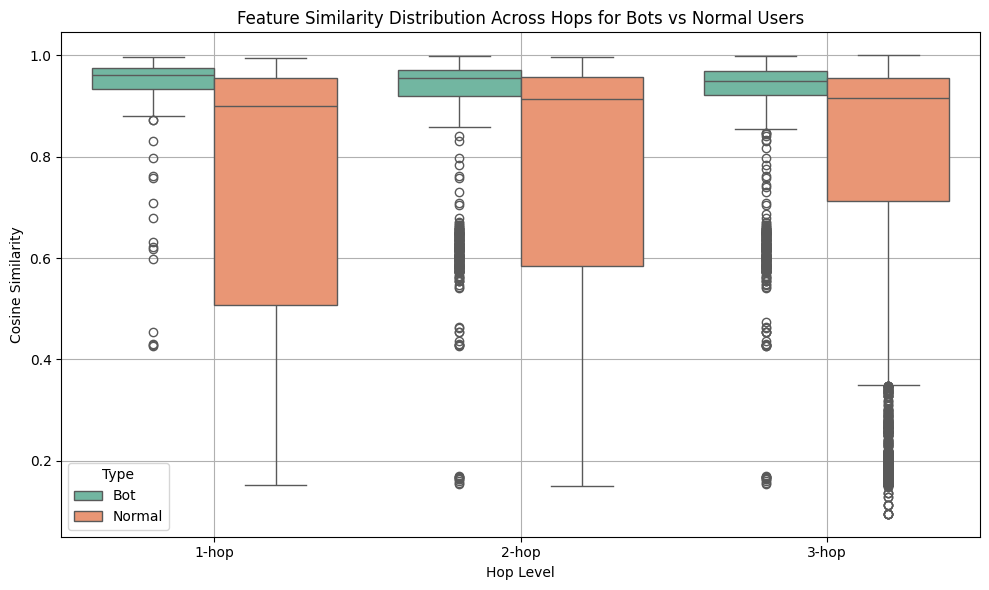

In [6]:
# 绘图
plot_similarity_distribution(sim_results)


In [7]:
sim_results

{1: {'bot': [0.9864110946655273,
   0.9886891841888428,
   0.9273133277893066,
   0.9426271319389343,
   0.9592576026916504,
   0.9043435454368591,
   0.9651808738708496,
   0.9544694423675537,
   0.9246812462806702,
   0.9554218053817749,
   0.9364086389541626,
   0.9681916236877441,
   0.9429430961608887,
   0.9498500227928162,
   0.9729592800140381,
   0.9690386056900024,
   0.9037925004959106,
   0.9542667865753174,
   0.9756245613098145,
   0.931801974773407,
   0.9160393476486206,
   0.9344143271446228,
   0.9713810682296753,
   0.9551862478256226,
   0.9674608707427979,
   0.9736213684082031,
   0.9413500428199768,
   0.9582024216651917,
   0.9016331434249878,
   0.9540457129478455,
   0.9119669198989868,
   0.9082072973251343,
   0.9063811898231506,
   0.968031108379364,
   0.9768815636634827,
   0.9187076687812805,
   0.9487387537956238,
   0.9563114047050476,
   0.9752334356307983,
   0.8955552577972412,
   0.9089886546134949,
   0.8962494730949402,
   0.8941364288330078,
   

In [8]:
for hop in sim_results:
    print(f"hop={hop}, keys={list(sim_results[hop].keys())}")

hop=1, keys=['bot', 'normal']
hop=2, keys=['bot', 'normal']
hop=3, keys=['bot', 'normal']


In [10]:
from scipy import stats

def plot_similarity_distribution(sim_dict):
    records = []
    statistical_results = []
    
    for hop in sim_dict:
        # 获取当前 hop 下的所有键
        available_labels = list(sim_dict[hop].keys())
        print('available_labels: ', available_labels)
        
        # 提取Bot和Normal用户的相似度值
        bot_sims = sim_dict[hop].get('bot', [])
        normal_sims = sim_dict[hop].get('normal', [])
        
        # 执行Mann-Whitney U检验
        statistic, p_value = stats.mannwhitneyu(bot_sims, normal_sims, alternative='two-sided')
        
        # 计算效应量（Cliff's Delta）
        d = cliffs_delta(bot_sims, normal_sims)
        
        statistical_results.append({
            'Hop': f'{hop}-hop',
            'Mann-Whitney U statistic': statistic,
            'p-value': p_value,
            "Cliff's Delta": d
        })
        
        # 构建绘图数据
        for label in available_labels:
            for sim in sim_dict[hop][label]:
                records.append({
                    'Similarity': sim,
                    'Hop': f'{hop}-hop',
                    'Type': 'Normal' if label == 'normal' else 'Bot'
                })

    # 创建统计结果表格
    stats_df = pd.DataFrame(statistical_results)
    print("\nStatistical Analysis Results:")
    print(stats_df.to_string(index=False))

    # 绘制箱线图
    df = pd.DataFrame(records)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Hop', y='Similarity', hue='Type', palette='Set2')
    plt.title("Feature Similarity Distribution Across Hops for Bots vs Normal Users")
    plt.xlabel("Hop Level")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 辅助函数：计算Cliff's Delta效应量
def cliffs_delta(group1, group2):
    n1 = len(group1)
    n2 = len(group2)
    dominance = 0
    
    for x in group1:
        for y in group2:
            if x > y:
                dominance += 1
            elif x < y:
                dominance -= 1
                
    return dominance / (n1 * n2)

available_labels:  ['bot', 'normal']
available_labels:  ['bot', 'normal']
available_labels:  ['bot', 'normal']

Statistical Analysis Results:
  Hop  Mann-Whitney U statistic       p-value  Cliff's Delta
1-hop                  693059.5  2.201953e-90       0.552040
2-hop                 3966308.5 1.999470e-116       0.390375
3-hop                23542818.0 2.833985e-281       0.390023


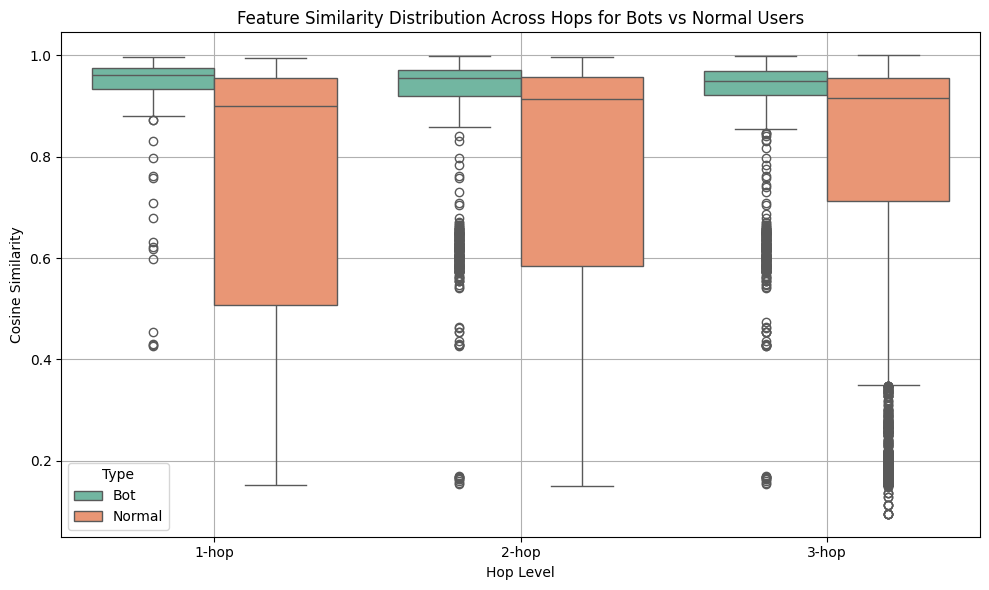

In [11]:
plot_similarity_distribution(sim_results)

In [13]:
def plot_similarity_distribution(sim_dict):
    records = []
    statistical_results = []
    
    for hop in sim_dict:
        # 获取当前 hop 下的所有键
        available_labels = list(sim_dict[hop].keys())
        print('available_labels: ', available_labels)
        
        # 提取Bot和Normal用户的相似度值
        bot_sims = np.array(sim_dict[hop].get('bot', []))
        normal_sims = np.array(sim_dict[hop].get('normal', []))
        
        # 执行Welch's t-test
        t_stat, p_value = stats.ttest_ind(bot_sims, normal_sims, equal_var=False)
        
        # 计算Cohen's d效应量
        n1, n2 = len(bot_sims), len(normal_sims)
        pooled_sd = np.sqrt(((n1-1)*np.var(bot_sims, ddof=1) + (n2-1)*np.var(normal_sims, ddof=1)) / (n1+n2-2))
        cohens_d = (np.mean(bot_sims) - np.mean(normal_sims)) / pooled_sd
        
        statistical_results.append({
            'Hop': f'{hop}-hop',
            't-statistic': t_stat,
            'p-value': p_value,
            "Cohen's d": cohens_d
        })
        
        # 构建绘图数据
        for label in available_labels:
            for sim in sim_dict[hop][label]:
                records.append({
                    'Similarity': sim,
                    'Hop': f'{hop}-hop',
                    'Type': 'Normal' if label == 'normal' else 'Bot'
                })

    # 创建统计结果表格
    stats_df = pd.DataFrame(statistical_results)
    print("\n统计分析结果:")
    print("----------------------------------------")
    for _, row in stats_df.iterrows():
        print(f"\n{row['Hop']}:")
        print(f"t-statistic: {row['t-statistic']:.4f}")
        print(f"p-value: {row['p-value']:.4e}")
        print("Cohen's d: {:.4f}".format(row["Cohen's d"]))
        
        # 解释效应量大小
        d = abs(row["Cohen's d"])
        if d < 0.2:
            effect_size = "可忽略的效应"
        elif d < 0.5:
            effect_size = "小效应"
        elif d < 0.8:
            effect_size = "中等效应"
        else:
            effect_size = "大效应"
        print(f"效应量大小: {effect_size}")

    # 绘制箱线图
    df = pd.DataFrame(records)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Hop', y='Similarity', hue='Type', palette='Set2')
    plt.title("Bot与Normal用户特征相似度分布对比")
    plt.xlabel("跳数层级")
    plt.ylabel("余弦相似度")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

available_labels:  ['bot', 'normal']
available_labels:  ['bot', 'normal']
available_labels:  ['bot', 'normal']

统计分析结果:
----------------------------------------

1-hop:
t-statistic: 26.8280
p-value: 2.9131e-130
Cohen's d: 0.9191
效应量大小: 大效应

2-hop:
t-statistic: 26.6036
p-value: 2.4132e-145
Cohen's d: 0.6534
效应量大小: 中等效应

3-hop:
t-statistic: 43.2872
p-value: 0.0000e+00
Cohen's d: 0.6640
效应量大小: 中等效应


/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 36339 (\N{CJK UNIFIED IDEOGRAPH-8DF3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 24358 (\N{CJK UNIFIED IDEOGRAPH-5F26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2236688/2807114734.py:68: UserWarning: Glyph 30456 (\N{CJK UN

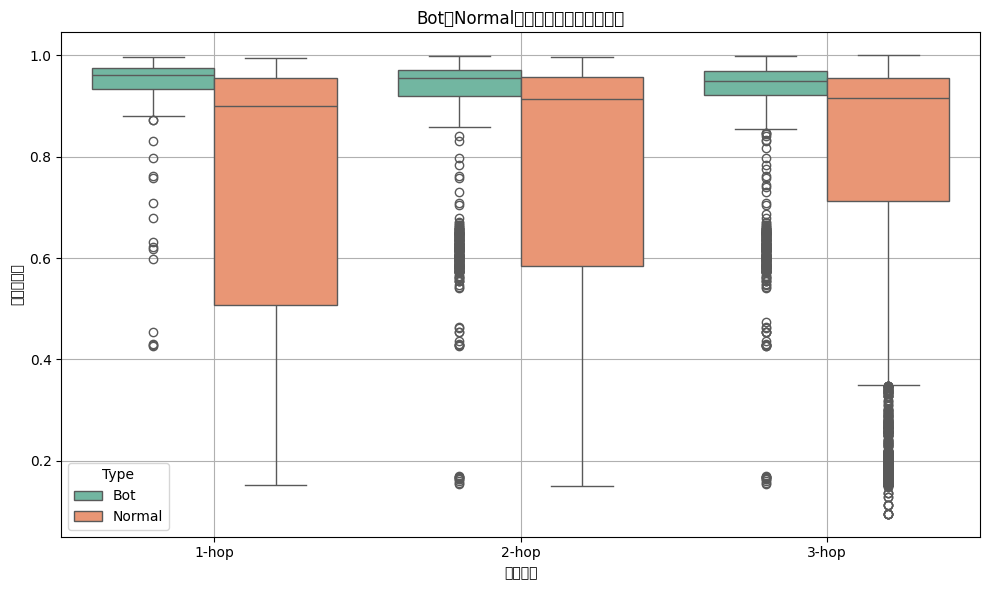

In [14]:
plot_similarity_distribution(sim_results)

## group-wise learner

In [25]:
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def groupwise_clustering_analysis(data, num_clusters=20):
    features = data.x.cpu().numpy()
    labels = data.y.cpu().numpy()
    test_idx = data.test_idx.cpu().numpy()

    # 获取 test set 中的机器人和正常用户
    test_features = features[test_idx]
    test_labels = labels[test_idx]

    mask_bot = test_labels == 1
    mask_normal = test_labels == 0

    # 降维以便 KMeans 更稳（可选）
    reduced_features = PCA(n_components=16).fit_transform(test_features)

    # 聚类
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_features)

    df = pd.DataFrame({
        'Cluster': cluster_labels,
        'Label': test_labels
    })

    # 统计各簇中机器人/正常用户数量
    bot_distribution = df[df['Label'] == 1]['Cluster'].value_counts(normalize=True)
    normal_distribution = df[df['Label'] == 0]['Cluster'].value_counts(normalize=True)

    bot_distribution = bot_distribution.rename('Bot')
    normal_distribution = normal_distribution.rename('Normal')
    combined = pd.concat([bot_distribution, normal_distribution], axis=1).fillna(0)
    combined = pd.concat([bot_distribution, normal_distribution], axis=1).fillna(0)
    combined['Cluster'] = combined.index  # 显式创建 id 列
    combined = pd.melt(combined, id_vars=['Cluster'], value_vars=['Bot', 'Normal'],
                    var_name='Type', value_name='Proportion')
    # combined = pd.melt(combined, id_vars=['index'], value_vars=['Bot', 'Normal'],
    #                    var_name='Type', value_name='Proportion')

    return combined


In [28]:
def plot_groupwise_distribution(combined_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=combined_df, x='Cluster', y='Proportion', hue='Type', palette='Set2')
    plt.xlabel("Cluster ID")
    plt.ylabel("Proportion of Nodes")
    plt.title("Distribution of Bots vs Normal Users Across Clusters")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [26]:
combined_df = groupwise_clustering_analysis(data, num_clusters=20)
combined_df

,Cluster,Type,Proportion
0,14,Bot,0.187500
1,9,Bot,0.131250
2,13,Bot,0.128125
3,7,Bot,0.118750
4,3,Bot,0.117188
5,16,Bot,0.103125
6,19,Bot,0.092188
7,11,Bot,0.078125
8,0,Bot,0.037500
9,4,Bot,0.004687


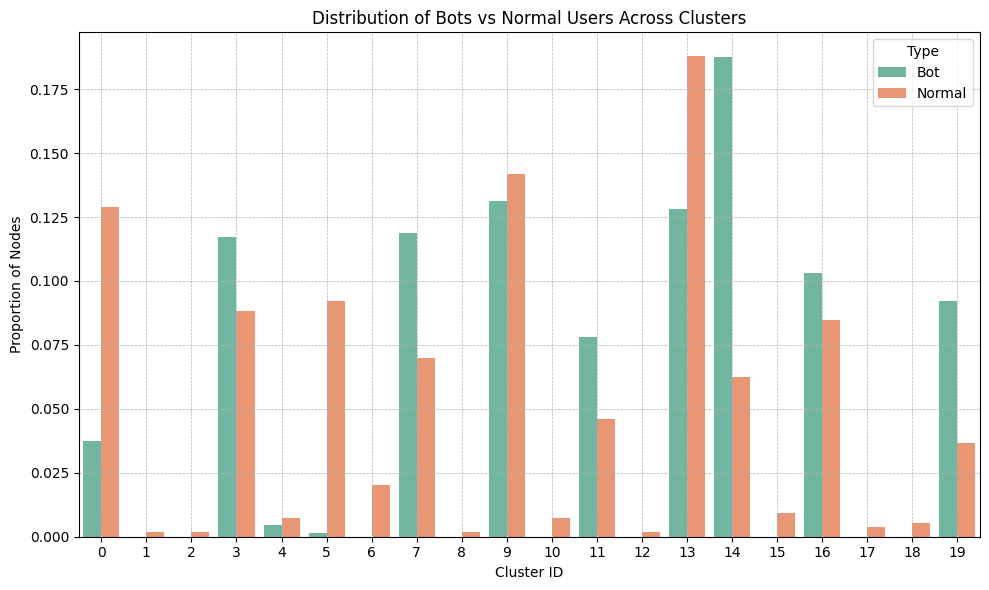

In [29]:
plot_groupwise_distribution(combined_df)


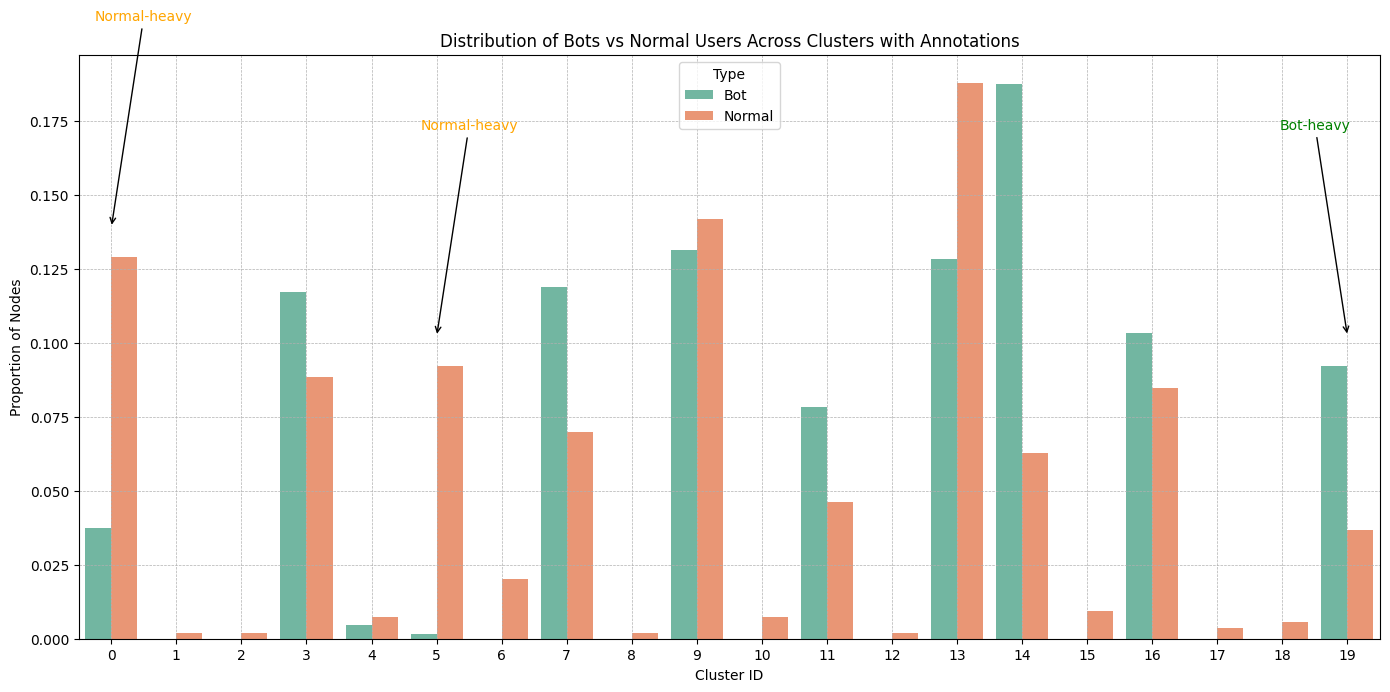

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 示例数据（你应使用实际从 groupwise_clustering_analysis() 得到的 combined_df）
# 如果你已有 CSV，取消下面这两行并改为：combined_df = pd.read_csv("your_file.csv")
# 例如：combined_df = pd.read_csv("combined_df_groupwise.csv")
# 请确保列名为：'Cluster', 'Proportion', 'Type'

# Step 1: 读入数据
# combined_df = pd.read_csv("/mnt/data/combined_df_groupwise.csv")  # 替换成你的路径或 DataFrame

# Step 2: 筛选出 bot-heavy 和 normal-heavy 的 cluster（阈值可调）
pivot_df = combined_df.pivot(index="Cluster", columns="Type", values="Proportion").fillna(0)
pivot_df["Bot-heavy"] = pivot_df["Bot"] > pivot_df["Normal"] + 0.05
pivot_df["Normal-heavy"] = pivot_df["Normal"] > pivot_df["Bot"] + 0.05
bot_heavy_clusters = pivot_df[pivot_df["Bot-heavy"]].index.tolist()
normal_heavy_clusters = pivot_df[pivot_df["Normal-heavy"]].index.tolist()

# Step 3: 绘图
plt.figure(figsize=(14, 7))
sns.barplot(data=combined_df, x='Cluster', y='Proportion', hue='Type', palette='Set2')

# Step 4: 添加箭头和注释
for cluster_id in bot_heavy_clusters:
    y = pivot_df.loc[cluster_id, "Bot"]
    plt.annotate('Bot-heavy',
                 xy=(cluster_id, y + 0.01),
                 xytext=(cluster_id - 0.5, y + 0.08),
                 arrowprops=dict(facecolor='green', arrowstyle='->'),
                 fontsize=10, color='green', ha='center')

for cluster_id in normal_heavy_clusters:
    y = pivot_df.loc[cluster_id, "Normal"]
    plt.annotate('Normal-heavy',
                 xy=(cluster_id, y + 0.01),
                 xytext=(cluster_id + 0.5, y + 0.08),
                 arrowprops=dict(facecolor='orange', arrowstyle='->'),
                 fontsize=10, color='orange', ha='center')

plt.xlabel("Cluster ID")
plt.ylabel("Proportion of Nodes")
plt.title("Distribution of Bots vs Normal Users Across Clusters with Annotations")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from tqdm import tqdm

def compute_cluster_stats(data, num_clusters=20):
    """
    计算每个聚类的统计信息，使用向量化操作提高效率
    
    参数:
        data: 包含 'cluster' 和标签列的 DataFrame
        num_clusters: 聚类数量
    
    返回:
        包含每个聚类统计信息的 DataFrame
    """
    # 确保 data 中有 'cluster' 列
    if 'cluster' not in data.columns:
        raise ValueError("数据中必须包含 'cluster' 列")
    
    # 初始化结果 DataFrame
    stats = []
    
    # 一次性计算所有聚类的统计信息
    cluster_counts = data['cluster'].value_counts().sort_index()
    
    # 假设 'label' 列表示 bot (1) 或 normal (0)
    # 如果标签列名不是 'label'，请替换为实际的列名
    label_col = 'label' if 'label' in data.columns else 'bot'
    
    # 使用 groupby 一次性计算所有聚类的 bot 比例
    bot_ratios = data.groupby('cluster')[label_col].mean()
    
    # 计算每个聚类的统计信息
    for cluster_id in range(num_clusters):
        if cluster_id in cluster_counts.index:
            cluster_size = cluster_counts[cluster_id]
            bot_ratio = bot_ratios.get(cluster_id, 0)
            
            stats.append({
                'Cluster': cluster_id,
                'Size': cluster_size,
                'Bot_Ratio': bot_ratio,
                'Bot_Count': int(bot_ratio * cluster_size),
                'Normal_Count': int((1 - bot_ratio) * cluster_size)
            })
        else:
            # 处理空聚类
            stats.append({
                'Cluster': cluster_id,
                'Size': 0,
                'Bot_Ratio': 0,
                'Bot_Count': 0,
                'Normal_Count': 0
            })
    
    # 创建结果 DataFrame 并排序
    stats_df = pd.DataFrame(stats)
    stats_df = stats_df.sort_values('Size', ascending=False).reset_index(drop=True)
    
    return stats_df


In [ ]:
stats_df = compute_cluster_stats(data, num_clusters=20)
print(stats_df)

# 如需保存：
stats_df.to_csv("cluster_stats.csv", index=False)


/users/Min/miniconda/envs/hy/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
